# Analysis for Section 5.3

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# src files
from situation_testing.situation_testing import SituationTesting
# plot params
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [2]:
# working directory and relevant folders
wd = os.path.dirname(os.getcwd())
data_path = os.path.abspath(os.path.join(wd, 'data')) + '\\'
resu_path = os.path.abspath(os.path.join(wd, 'results')) + '\\'
figu_path = resu_path + 'figures' + '\\'

## Plots for k-analysis

In [3]:
# Gender (G)
g_k_results = pd.read_csv(resu_path + 'res_LawSchool_Male_abs.csv', sep='|')
# Race (R)
r_k_results = pd.read_csv(resu_path + 'res_LawSchool_White_abs.csv', sep='|')
# Multiple
multi_k_results = pd.read_csv(resu_path + 'res_LawSchool_Multiple_abs.csv', sep='|')
# Intersectional
inter_k_results = pd.read_csv(resu_path + 'res_LawSchool_MaleWhite_abs.csv', sep='|')

In [4]:
# For some methods, we find 0 cases at k=1, elading to NaNs in the significants measures | TODO: update code
g_k_results.fillna(0, inplace=True)
r_k_results.fillna(0, inplace=True)
multi_k_results.fillna(0, inplace=True)
inter_k_results.fillna(0, inplace=True)

In [5]:
# these results go from 1 to 500
K_l = 1
k_u = 500
x_axis = list(range(50, k_u + 1, 50))
x_axis.append(1)
x_axis = sorted(x_axis)
x_axis

[1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

### Single discrimination based w.r.t. G: CST w/o and ST

In [ ]:
# plt.plot(g_k_results['k'], g_k_results['CSTwo_delta'], label='CST w/o')
# plt.plot(g_k_results['k'], g_k_results['ST_delta'], label='ST')
# plt.plot(g_k_results['k'], g_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
# plt.plot(g_k_results['k'], g_k_results['ST_delta_sig'], label='ST (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0.0, 1.05)
# plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $G$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs ST')
# plt.savefig(os.path.join(figu_path, 'G_CSTwoVsST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.plot(g_k_results['k'], g_k_results['CSTwo'], label='CST w/o')
# plt.plot(g_k_results['k'], g_k_results['ST'], label='ST')
# plt.plot(g_k_results['k'], g_k_results['CSTwo_sig'], label='CST w/o (sig.)')
# plt.plot(g_k_results['k'], g_k_results['ST_sig'], label='ST (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.ylim(0, g_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.ylabel("Num. of discrimination cases w.r.t. $G$")
# plt.legend()
# # plt.title('CST w/o vs ST')
# plt.savefig(os.path.join(figu_path, 'G_CSTwoVsST_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimination w.r.t. R: CST w/o and ST

In [ ]:
# plt.plot(r_k_results['k'], r_k_results['CSTwo_delta'], label='CST w/o')
# plt.plot(r_k_results['k'], r_k_results['ST_delta'], label='ST')
# plt.plot(r_k_results['k'], r_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
# plt.plot(r_k_results['k'], r_k_results['ST_delta_sig'], label='ST (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0.0, 1.05)
# plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $R$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs ST')
# plt.savefig(os.path.join(figu_path, 'R_CSTwoVsST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.plot(r_k_results['k'], r_k_results['CSTwo'], label='CST w/o')
# plt.plot(r_k_results['k'], r_k_results['ST'], label='ST')
# plt.plot(r_k_results['k'], r_k_results['CSTwo_sig'], label='CST w/o (sig.)')
# plt.plot(r_k_results['k'], r_k_results['ST_sig'], label='ST (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0, r_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.ylabel("Num. of discrimination cases w.r.t. $R$")
# plt.legend()
# # plt.title('CST w/o vs ST')
# plt.savefig(os.path.join(figu_path, 'R_CSTwoVsST_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimination based w.r.t. G: CST w/ and CF

In [ ]:
# plt.plot(g_k_results['k'], g_k_results['CSTwi'], label='CST w/')
# plt.plot(g_k_results['k'], g_k_results['CF'], label='CF')
# plt.plot(g_k_results['k'], g_k_results['CSTwi_sig'], label='CST w/ (sig.)')
# plt.plot(g_k_results['k'], g_k_results['CF_sig'], label='CF (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0, g_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.ylabel("Num. of discrimination cases w.r.t. $G$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/ vs CF')
# plt.savefig(os.path.join(figu_path, 'G_CSTwiVsCF_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimination based w.r.t. R: CST w/ and CF

In [ ]:
# plt.plot(r_k_results['k'], r_k_results['CSTwi'], label='CST w/')
# plt.plot(r_k_results['k'], r_k_results['CF'], label='CF')
# plt.plot(r_k_results['k'], r_k_results['CSTwi_sig'], label='CST w/ (sig.)')
# plt.plot(r_k_results['k'], r_k_results['CF_sig'], label='CF (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0, r_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.ylabel("Num. of discrimination cases w.r.t. $R$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/ vs CF')
# plt.savefig(os.path.join(figu_path, 'R_CSTwiVsCF_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimination based w.r.t. G: CST w/o and CST w/

In [ ]:
# plt.plot(g_k_results['k'], g_k_results['CSTwo_delta'], label='CST w/o')
# plt.plot(g_k_results['k'], g_k_results['CSTwi_delta'], label='CST w/')
# plt.plot(g_k_results['k'], g_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
# plt.plot(g_k_results['k'], g_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0.0, 1.05)
# plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $G$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'G_TwoCST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.plot(g_k_results['k'], g_k_results['CSTwo'], label='CST w/o')
# plt.plot(g_k_results['k'], g_k_results['CSTwi'], label='CST w/')
# plt.plot(g_k_results['k'], g_k_results['CSTwo_sig'], label='CST w/o (sig.)')
# plt.plot(g_k_results['k'], g_k_results['CSTwi_sig'], label='CST w/ (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0, g_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.ylabel("Num. of discrimination cases w.r.t. $G$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'G_TwoCST_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimination based w.r.t. R: CST w/o and CST w/

In [ ]:
# plt.plot(r_k_results['k'], r_k_results['CSTwo_delta'], label='CST w/o')
# plt.plot(r_k_results['k'], r_k_results['CSTwi_delta'], label='CST w/')
# plt.plot(r_k_results['k'], r_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
# plt.plot(r_k_results['k'], r_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0.0, 1.05)
# plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $R$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'R_TwoCST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.plot(r_k_results['k'], r_k_results['CSTwo'], label='CST w/o')
# plt.plot(r_k_results['k'], r_k_results['CSTwi'], label='CST w/')
# plt.plot(r_k_results['k'], r_k_results['CSTwo_sig'], label='CST w/o (sig.)')
# plt.plot(r_k_results['k'], r_k_results['CSTwi_sig'], label='CST w/ (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0, g_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.ylabel("Num. of discrimination cases w.r.t. $R$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'R_TwoCST_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimiantion: all together

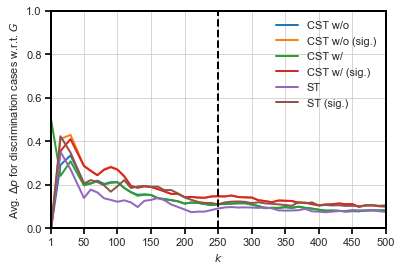

In [6]:
plt.plot(g_k_results['k'], g_k_results['CSTwo_delta'], label='CST w/o')
plt.plot(g_k_results['k'], g_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
plt.plot(g_k_results['k'], g_k_results['CSTwi_delta'], label='CST w/')
plt.plot(g_k_results['k'], g_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
plt.plot(g_k_results['k'], g_k_results['ST_delta'], label='ST')
plt.plot(g_k_results['k'], g_k_results['ST_delta_sig'], label='ST (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0.0, 1.0)
plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $G$")
plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.legend(loc='upper right', ncol=1, fancybox=True)
plt.savefig(os.path.join(figu_path, 'G_all_delta_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

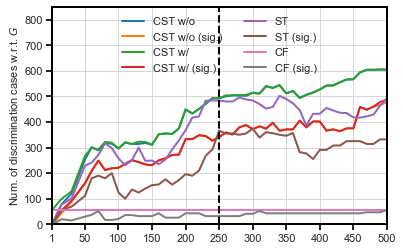

In [7]:
plt.plot(g_k_results['k'], g_k_results['CSTwo'], label='CST w/o')
plt.plot(g_k_results['k'], g_k_results['CSTwo_sig'], label='CST w/o (sig.)')
plt.plot(g_k_results['k'], g_k_results['CSTwi'], label='CST w/')
plt.plot(g_k_results['k'], g_k_results['CSTwi_sig'], label='CST w/ (sig.)')
plt.plot(g_k_results['k'], g_k_results['ST'], label='ST')
plt.plot(g_k_results['k'], g_k_results['ST_sig'], label='ST (sig.)')
plt.plot(g_k_results['k'], g_k_results['CF'], label='CF')
plt.plot(g_k_results['k'], g_k_results['CF_sig'], label='CF (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.ylim(0, 850) #g_k_results.iloc[-1].max() + 15)
# plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.ylabel("Num. of discrimination cases w.r.t. $G$")
plt.legend(loc='upper center', ncol=2, fancybox=True)
# plt.title('CST w/o vs ST')
plt.savefig(os.path.join(figu_path, 'G_all_nums_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

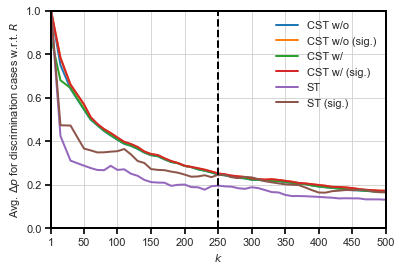

In [8]:
plt.plot(r_k_results['k'], r_k_results['CSTwo_delta'], label='CST w/o')
plt.plot(r_k_results['k'], r_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
plt.plot(r_k_results['k'], r_k_results['CSTwi_delta'], label='CST w/')
plt.plot(r_k_results['k'], r_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
plt.plot(r_k_results['k'], r_k_results['ST_delta'], label='ST')
plt.plot(r_k_results['k'], r_k_results['ST_delta_sig'], label='ST (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0.0, 1.0)
plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $R$")
plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.legend(loc='upper right', ncol=1, fancybox=True)
plt.savefig(os.path.join(figu_path, 'R_all_delta_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

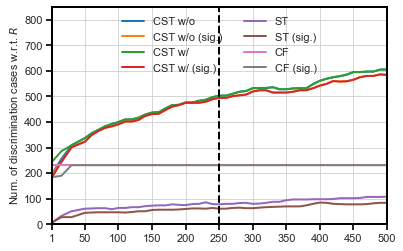

In [9]:
plt.plot(r_k_results['k'], r_k_results['CSTwo'], label='CST w/o')
plt.plot(r_k_results['k'], r_k_results['CSTwo_sig'], label='CST w/o (sig.)')
plt.plot(r_k_results['k'], r_k_results['CSTwi'], label='CST w/')
plt.plot(r_k_results['k'], r_k_results['CSTwi_sig'], label='CST w/ (sig.)')
plt.plot(r_k_results['k'], r_k_results['ST'], label='ST')
plt.plot(r_k_results['k'], r_k_results['ST_sig'], label='ST (sig.)')
plt.plot(r_k_results['k'], r_k_results['CF'], label='CF')
plt.plot(r_k_results['k'], r_k_results['CF_sig'], label='CF (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.ylim(0, 850) #g_k_results.iloc[-1].max() + 15)
# plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.ylabel("Num. of discrimination cases w.r.t. $R$")
plt.legend(loc='upper center', ncol=2, fancybox=True)
# plt.title('CST w/o vs ST')
plt.savefig(os.path.join(figu_path, 'R_all_nums_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

### Multiple discrimination

In [ ]:
plt.plot(multi_k_results['k'], multi_k_results['ST_delta'], label='ST')
plt.plot(multi_k_results['k'], multi_k_results['ST_delta_sig'], label='ST (sig.)')
plt.plot(multi_k_results['k'], multi_k_results['CSTwo_delta'], label='CST w/o')
plt.plot(multi_k_results['k'], multi_k_results['CSTwi_delta'], label='CST w/')
plt.plot(multi_k_results['k'], multi_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
plt.plot(multi_k_results['k'], multi_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0.0, 1.05)
plt.ylabel("Avg. $\Delta p$ for multi. discrimination cases")
plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
plt.legend()
# plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'R_TwoCST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(multi_k_results['k'], multi_k_results['ST'], label='ST')
plt.plot(multi_k_results['k'], multi_k_results['CSTwo'], label='CST w/o')
plt.plot(multi_k_results['k'], multi_k_results['CSTwi'], label='CST w/')
plt.plot(multi_k_results['k'], multi_k_results['ST_sig'], label='ST (sig.)')
plt.plot(multi_k_results['k'], multi_k_results['CSTwo_sig'], label='CST w/o (sig.)')
plt.plot(multi_k_results['k'], multi_k_results['CSTwi_sig'], label='CST w/ (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0, 150) #multi_k_results.iloc[-1].max() + 15)
plt.ylabel("Num. of multi. discrimination cases")
plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
plt.legend()
# plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'R_TwoCST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

### Intersectional discrimination

In [ ]:
plt.plot(inter_k_results['k'], inter_k_results['ST_delta'], label='ST')
plt.plot(inter_k_results['k'], inter_k_results['ST_delta_sig'], label='ST (sig.)')
plt.plot(inter_k_results['k'], inter_k_results['CSTwo_delta'], label='CST w/o')
plt.plot(inter_k_results['k'], inter_k_results['CSTwi_delta'], label='CST w/')
plt.plot(inter_k_results['k'], inter_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
plt.plot(inter_k_results['k'], inter_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0.0, 1.05)
plt.ylabel("Avg. $\Delta p$ for inter. discrimination cases")
plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
plt.legend()
# plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'R_TwoCST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(inter_k_results['k'], inter_k_results['ST'], label='ST')
plt.plot(inter_k_results['k'], inter_k_results['CSTwo'], label='CST w/o')
plt.plot(inter_k_results['k'], inter_k_results['CSTwi'], label='CST w/')
plt.plot(inter_k_results['k'], inter_k_results['ST_sig'], label='ST (sig.)')
plt.plot(inter_k_results['k'], inter_k_results['CSTwo_sig'], label='CST w/o (sig.)')
plt.plot(inter_k_results['k'], inter_k_results['CSTwi_sig'], label='CST w/ (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0, 250) #inter_k_results.iloc[-1].max() + 15)
plt.ylabel("Num. of inter. discrimination cases")
plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
plt.legend()
# plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'R_TwoCST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

## Summary stats: general and for a given $k$

In [ ]:
# load and modify factual data (same for counterfactual data)
org_df = pd.read_csv(data_path + 'clean_LawSchool.csv', sep='|').reset_index(drop=True)
# print(org_df.shape)
# print(org_df.columns.to_list())
# org_df.head(5)
# we focus on sex and race_nonwhite
df = org_df[['sex', 'race_nonwhite', 'LSAT', 'UGPA']].copy()
# df['sex'] = df['sex'].map({'Male': 0, 'Female': 1})
# df['race_nonwhite'] = df['race_nonwhite'].map({'White': 0, 'NonWhite': 1})
df.rename(columns={'sex': 'Gender', 'race_nonwhite': 'Race'}, inplace=True)
df.head(5)

## A 'known' decision maker

An DM based on [the known requirements of US Law Schools](https://schools.lawschoolnumbers.com/). We assume the case for Yale School. We could not find a one-to-one converter between LSAT over 48 to over 180. 173/180 is 96%: it would be about 46.1/48. We assume Yale cuts at these median values, and puts a higher weight on UGPA.

In [ ]:
def add_dm(df: pd.DataFrame):
    b1 = 0.6
    b2 = 0.4
    min_score = round(b1 * 3.93 + b2 * 46.1, 2)  # 20.8
    max_score = round(b1 * 4.00 + b2 * 48.00)    # 22
    df['Score'] = b1 * df['UGPA'] + b2 * df['LSAT']
    df['Y'] = np.where(df['Score'] >= min_score, 1, 0)
    return df

In [ ]:
df = add_dm(df)
df.head(5)

## Summary statistics

In [ ]:
print('Num. of applicants')
print(df.shape[0])
###
print('Females')
print(df[df['Gender'] == 'Female'].shape[0])
print(df[df['Gender'] == 'Female'].shape[0] / df.shape[0] * 100)
###
print('Non-whites')
print(df[df['Race'] == 'NonWhite'].shape[0])
print(df[df['Race'] == 'NonWhite'].shape[0] / df.shape[0] * 100)
###
print('Female-non-whites')
print(df[(df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0])
print(df[(df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0] / df.shape[0] * 100)

In [ ]:
print('Num. of accepted applicants')
print(df[df['Y'] == 1].shape[0])
print(df[df['Y'] == 1].shape[0] / df.shape[0] * 100)
###
print('Females')
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female')].shape[0])
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female')].shape[0] / df.shape[0] * 100)
print('Males')
print(df[(df['Y'] == 1) & (df['Gender'] == 'Male')].shape[0])
print(df[(df['Y'] == 1) & (df['Gender'] == 'Male')].shape[0] / df.shape[0] * 100)
###
print('Non-whites')
print(df[(df['Y'] == 1) & (df['Race'] == 'NonWhite')].shape[0])
print(df[(df['Y'] == 1) & (df['Race'] == 'NonWhite')].shape[0] / df.shape[0] * 100)
print('Whites')
print(df[(df['Y'] == 1) & (df['Race'] == 'White')].shape[0])
print(df[(df['Y'] == 1) & (df['Race'] == 'White')].shape[0] / df.shape[0] * 100)
###
print('Female-non-whites')
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0])
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0] / df.shape[0] * 100)
print('All but female-non-whites')
tot = df[(df['Y'] == 1) & (df['Gender'] == 'Female') & (df['Race'] == 'White')].shape[0] + df[(df['Y'] == 1) & (df['Gender'] == 'Male') & (df['Race'] == 'NonWhite')].shape[0] + df[(df['Y'] == 1) & (df['Gender'] == 'Male') & (df['Race'] == 'White')].shape[0]
print(tot)
print(tot / df.shape[0] * 100)


## Params for the analysis

In [ ]:
# size of neighborhoods
n = 15
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

## $|\mathbf{A}=1|$: Gender

In [ ]:
do = 'Male'
org_cf_df = pd.read_csv(data_path + '\\counterfactuals\\' + f'cf_LawSchool_lev3_do{do}.csv', sep='|').reset_index(drop=True)
cf_df = org_cf_df[['Sex', 'Race', 'scf_LSAT', 'scf_UGPA']].copy()
cf_df = cf_df.rename(columns={'Sex': 'Gender', 'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})
cf_df = add_dm(cf_df)
cf_df.head(5)

In [ ]:
# --- attribute-specific params
feat_trgt = 'Y'
feat_trgt_vals = {'positive': 1, 'negative': 0}
# list of relevant features
feat_rlvt = ['LSAT', 'UGPA']
# protected feature
feat_prot = 'Gender'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': 'Male', 'protected': 'Female'}

In [ ]:
# b = 35
# plt.hist(df[df['Gender'] == 'Female']['LSAT'], bins=b, alpha=0.9, label=r'$LSAT^F$')
# plt.hist(cf_df[cf_df['Gender'] == 'Female']['LSAT'], bins=b, alpha=0.5, label=r'$LSAT^{CF}$')
# plt.legend(loc='upper left')
# plt.ylabel('Frequency')
# plt.xlabel(r'LSAT for females')

In [ ]:
# b = 35
# plt.hist(df[df['Gender'] == 'Female']['UGPA'], bins=b, alpha=0.9, label=r'$UGPA^F$')
# plt.hist(cf_df[cf_df['Gender'] == 'Female']['UGPA'], bins=b, alpha=0.5, label=r'$UGPA^{CF}$')
# plt.legend(loc='upper left')
# plt.ylabel('Frequency')
# plt.xlabel(r'UGPA for females')

In [ ]:
### get disc??? TODO
# store do:=Male results
m_res_df = df[['Gender', 'Race', 'Y']].copy()
m_res_df['cf_Y'] = cf_df[['Y']].copy()
m_res_df.head(5)

### Situation Testing

Notice that, by construction, by not specifying 'Race' (or 'Gender') as a relevant feature, ST will ignore it.

In [ ]:
test_df = df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Gender'], continuous_atts=['LSAT', 'UGPA'])

m_res_df['stST'] = st.run(target_att=feat_trgt, target_val=feat_trgt_vals,  
                          sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                          k=n, alpha=alpha, tau=tau)

In [ ]:
m_res_df[(m_res_df['stST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
m_res_df[(m_res_df['stST'] < tau)].shape[0]

### Counterfactual Situation Testing w/o

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# don't include the centers
cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['LSAT', 'UGPA'])

m_res_df['cfST'] = cf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                             sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                             include_centers=False,
                             k=n, alpha=alpha, tau=tau)

In [ ]:
m_res_df[(m_res_df['cfST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
m_res_df[(m_res_df['cfST'] < tau)].shape[0]

#### Counterfactual Fairness

In [ ]:
m_res_df['CF'] = cf_st.res_counterfactual_unfairness

In [ ]:
m_res_df[m_res_df['CF'] == 1].shape[0]

In [ ]:
# positive discrimination?
m_res_df[m_res_df['CF'] == 2].shape[0] 

#### cfST with centers

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# don't include the centers
wcf_st = SituationTesting()
wcf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['LSAT', 'UGPA'])

m_res_df['cfST_w'] = wcf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                                sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                                include_centers=True,
                                k=n, alpha=alpha, tau=tau)

In [ ]:
m_res_df[(m_res_df['cfST_w'] > tau)].shape[0]

In [ ]:
# positive discrimination?
m_res_df[(m_res_df['cfST_w'] < tau)].shape[0]

### Add CIs for CF

In [ ]:
df_wcf_sf_disc = wcf_st.get_test_discrimination()
df_wcf_sf_disc.head(5)

In [ ]:
# add this to results to showcase the method
df_wcf_sf_disc[df_wcf_sf_disc['individual'].isin(m_res_df[m_res_df['CF'] == True].index.to_list())].head(5)

### $|\mathbf{A}=1|$: Race

In [ ]:
do = 'White'
org_cf_df = pd.read_csv(data_path + '\\counterfactuals\\' + f'cf_LawSchool_lev3_do{do}.csv', sep='|').reset_index(drop=True)
print(org_cf_df.shape)
print(org_cf_df.columns.to_list())
org_cf_df.head(5)

In [ ]:
cf_df = org_cf_df[['Sex', 'Race', 'scf_LSAT', 'scf_UGPA']].copy()
cf_df = cf_df.rename(columns={'Sex': 'Gender', 'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})

# add the decision maker
cf_df['Score'] = b1*cf_df['UGPA'] + b2*cf_df['LSAT']
cf_df['Y'] = np.where(cf_df['Score'] >= min_score, 1, 0)
cf_df.head(5)

In [ ]:
b = 35
plt.hist(df[df['Race'] == 'NonWhite']['LSAT'], bins=b, alpha=0.9, label=r'$LSAT^F$')
plt.hist(cf_df[cf_df['Race'] == 'NonWhite']['LSAT'], bins=b, alpha=0.5, label=r'$LSAT^{CF}$')
plt.legend(loc='upper left')
plt.ylabel('Frequency')
plt.xlabel(r'LSAT for non-whites')

In [ ]:
b = 25
plt.hist(df[df['Race'] == 'NonWhite']['UGPA'], bins=b, alpha=0.9, label=r'$UGPA^F$')
plt.hist(cf_df[cf_df['Race'] == 'NonWhite']['UGPA'], bins=b, alpha=0.5, label=r'$UGPA^{CF}$')
plt.legend(loc='upper left')
plt.ylabel('Frequency')
plt.xlabel(r'UGPA for non-whites')

In [ ]:
# df.groupby(['Y', 'Race']).count()
# cf_df.groupby(['Y', 'Race']).count()

In [ ]:
# store do:=White results
w_res_df = df[['Gender', 'Race', 'Y']].copy()
w_res_df['cf_Y'] = cf_df[['Y']].copy()
w_res_df.head(5)

In [ ]:
# attribute-specific params
feat_trgt = 'Y'
feat_trgt_vals = {'positive': 1, 'negative': 0}
# list of relevant features
feat_rlvt = ['LSAT', 'UGPA']
# protected feature
feat_prot = 'Race'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': 'White', 'protected': 'NonWhite'}

# st-specific params
# size of neiuborhoods
n = 15
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

#### Standard ST (stST)

Notice that, by construction, by not specifying 'Race' (or 'Gender') as a relevant feature, ST will ignore it.

In [ ]:
test_df = df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

w_res_df['stST'] = st.run(target_att=feat_trgt, target_val=feat_trgt_vals,  
                          sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                          k=n, alpha=alpha, tau=tau)

In [ ]:
w_res_df[(w_res_df['stST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
w_res_df[(w_res_df['stST'] < tau)].shape[0]

#### Counterfactual Situation Testing (cfST)

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# don't include the centers
cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

w_res_df['cfST'] = cf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                             sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                             include_centers=False,
                             k=n, alpha=alpha, tau=tau)

In [ ]:
w_res_df[(w_res_df['cfST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
w_res_df[(w_res_df['cfST'] < tau)].shape[0]

#### Counterfactual Fairness

In [ ]:
w_res_df['CF'] = cf_st.res_counterfactual_unfairness

In [ ]:
w_res_df[w_res_df['CF'] == 1].shape[0]

In [ ]:
w_res_df[w_res_df['CF'] == 2].shape[0]

#### cfST with centers

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# include the centers
wcf_st = SituationTesting()
wcf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

w_res_df['cfST_w'] = wcf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                                sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                                include_centers=True,
                                k=n, alpha=alpha, tau=tau)

In [ ]:
w_res_df[(w_res_df['cfST_w'] > tau)].shape[0]

In [ ]:
# positive discrimination?
w_res_df[(w_res_df['cfST_w'] < tau)].shape[0]

### Multiple discrimination: $|\mathbf{A}|=2$

In [ ]:
df[(df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0]

In [ ]:
# for stST
pd.merge(left=m_res_df[m_res_df['stST'] > tau], right=w_res_df[w_res_df['stST'] > tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for stST +
pd.merge(left=m_res_df[m_res_df['stST'] < tau], right=w_res_df[w_res_df['stST'] < tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for cfST
pd.merge(left=m_res_df[m_res_df['cfST'] > tau], right=w_res_df[w_res_df['cfST'] > tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for cfST +
pd.merge(left=m_res_df[m_res_df['cfST'] < tau], right=w_res_df[w_res_df['cfST'] < tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for stST_w
pd.merge(left=m_res_df[m_res_df['cfST_w'] > tau], right=w_res_df[w_res_df['cfST_w'] > tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for stST_w +
pd.merge(left=m_res_df[m_res_df['cfST_w'] < tau], right=w_res_df[w_res_df['cfST_w'] < tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for Counterfactual Fairness
pd.merge(left=m_res_df[m_res_df['CF'] == 1], right=w_res_df[w_res_df['CF'] == 1], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for Counterfactual Fairness w +
pd.merge(left=m_res_df[m_res_df['CF'] == 2], right=w_res_df[w_res_df['CF'] == 2], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

### Intersectional Discrimination: $A_1 \cap A_2$

In [ ]:
do = 'MaleWhite'
org_cf_df = pd.read_csv(data_path + '\\counterfactuals\\' + f'cf_LawSchool_lev3_do{do}.csv', sep='|').reset_index(drop=True)
print(org_cf_df.shape)
print(org_cf_df.columns.to_list())
org_cf_df.head(5)

In [ ]:
cf_df = org_cf_df[['GenderRace', 'scf_LSAT', 'scf_UGPA']].copy()
cf_df = cf_df.rename(columns={'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})

# add the decision maker
cf_df['Score'] = b1*cf_df['UGPA'] + b2*cf_df['LSAT']
cf_df['Y'] = np.where(cf_df['Score'] >= min_score, 1, 0)
cf_df.head(5)

In [ ]:
# add the intersectional var to df
df.head()
df['GenderRace'] =  df['Gender'] + '-' + df['Race']
df.head(5)

In [ ]:
# df.groupby(['Y', 'GenderRace']).count()
# cf_df.groupby(['Y', 'GenderRace']).count()

In [ ]:
# store do:=White results
int_res_df = df[['Gender', 'Race', 'Y']].copy()
int_res_df['cf_Y'] = cf_df[['Y']].copy()
int_res_df.head(5)

In [ ]:
# attribute-specific params
feat_trgt = 'Y'
feat_trgt_vals = {'positive': 1, 'negative': 0}
# list of relevant features
feat_rlvt = ['LSAT', 'UGPA']
# protected feature
feat_prot = 'GenderRace'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': ['Female-White', 'Male-NonWhite', 'Male-NonWhite', 'Male-White'], 
                  'protected': 'Female-NonWhite'
                 }

# st-specific params
# size of neiuborhoods
n = 15
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

#### Standard ST (stST)

In [ ]:
test_df = df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['GenderRace'], continuous_atts=['LSAT', 'UGPA'])

int_res_df['stST'] = st.run(target_att=feat_trgt, target_val=feat_trgt_vals,
                            sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                            k=n, alpha=alpha, tau=tau)

In [ ]:
int_res_df[(int_res_df['stST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
int_res_df[(int_res_df['stST'] < tau)].shape[0]

#### Counterfactual Situation Testing (cfST)

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# don't include the centers
cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

int_res_df['cfST'] = cf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                               sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                               include_centers=False,
                               k=n, alpha=alpha, tau=tau)

In [ ]:
int_res_df[(int_res_df['cfST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
int_res_df[(int_res_df['cfST'] < tau)].shape[0]

#### Counterfactual Fairness

In [ ]:
int_res_df['CF'] = cf_st.res_counterfactual_unfairness

In [ ]:
int_res_df[int_res_df['CF'] == 1].shape[0]

In [ ]:
int_res_df[int_res_df['CF'] == 2].shape[0]

#### cfST with centers

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# include the centers
wcf_st = SituationTesting()
wcf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

int_res_df['cfST_w'] = wcf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                                  sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                                  include_centers=True,
                                  k=n, alpha=alpha, tau=tau)

In [ ]:
int_res_df[(int_res_df['cfST_w'] > tau)].shape[0]

In [ ]:
# positive discrimination?
int_res_df[(int_res_df['cfST_w'] < tau)].shape[0]